In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import norm
import statsmodels.stats.proportion as proportion
from joblib import Parallel, delayed
import math
import json
import ast

In [3]:
from google.oauth2 import service_account
pd.set_option('display.max_columns', None)
#from elasticsearch import Elasticsearch
#from peewee import MySQLDatabase

In [4]:
# Методы загрузки нужных данных из BQ
# Авторизация в bq
project_id = 'krisha-83abb'

path_to_credentials = r'C:\Users\adilbek\Jupyter Notebook Kolesa\Рассылка по понедельникам/'
credentials = path_to_credentials + 'krisha-83abb-4b7ed47d4d28.json'
credentials = service_account.Credentials.from_service_account_file(credentials)

In [8]:
query = """
SELECT
  event_date
  , global_id
  , SUM(rvn) AS revenue
  , SUM(money) AS money
  , SUM(dmd) AS demand
FROM
  `krisha-83abb.sandbox.an_6342_20240131`
WHERE
  action = 'view'
  AND (limit_dmd IS NULL OR limit_dmd = 0)
GROUP BY
  1,2
ORDER BY
  1
"""

bq_data = pd.read_gbq(query,
                      project_id = project_id,
                      credentials = credentials,
                      dialect = 'standard',
                      progress_bar_type = 'tqdm')
bq_data

Downloading: 100%|████████████████████████████████████████████████████████| 106166/106166 [00:06<00:00, 15620.34rows/s]


,event_date,global_id,revenue,money,demand
0,2024-01-22,20147502.000000000,<NA>,<NA>,<NA>
1,2024-01-22,19547851.000000000,<NA>,<NA>,<NA>
2,2024-01-22,1061181.000000000,<NA>,<NA>,<NA>
3,2024-01-22,20339955.000000000,<NA>,<NA>,<NA>
4,2024-01-22,707627.000000000,<NA>,<NA>,<NA>
...,...,...,...,...,...
106161,2024-01-30,675290.000000000,2080,2080,1
106162,2024-01-30,29113211.000000000,9775,9775,1
106163,2024-01-30,13593430.000000000,610,610,1
106164,2024-01-30,19036456.000000000,980,980,1


In [9]:
bq_data.to_csv('data_20240131.csv')

In [10]:
del bq_data

In [44]:
df = pd.read_csv('data_20240131.csv', parse_dates = ['event_date'])
df.fillna(0, inplace = True)
df = df.groupby(['global_id']).agg({'revenue': 'sum', 'money': 'sum', 'demand': 'sum'}).reset_index()
df['payers'] = np.where(df.money > 0, 1, 0)
df

,global_id,revenue,money,demand,payers
0,45.0,0.0,0.0,0.0,0
1,51.0,0.0,0.0,0.0,0
2,85.0,0.0,0.0,0.0,0
3,376.0,0.0,0.0,0.0,0
4,451.0,0.0,0.0,0.0,0
...,...,...,...,...,...
71668,31393766.0,0.0,0.0,0.0,0
71669,31393829.0,0.0,0.0,0.0,0
71670,31393911.0,805.0,805.0,1.0,1
71671,31393959.0,0.0,0.0,0.0,0


In [45]:
df['hash'] = (np.floor(df['global_id'].astype(int) / 10) % 100).astype(int)
df['group'] = np.where(df.hash < 25, 'group_2', 'group_1')
#df['hash'] = df.hash.astype(str).apply(lambda x: x.zfill(3))

In [46]:
data_piv_arpu = df.groupby(['group']).agg({'money': 'mean', 'global_id': 'nunique'}).reset_index().rename(columns = {'money': 'ARPU', 'global_id': 'users'})
data_piv_arppu = df.query("money > 0").groupby(['group']).agg({'money': 'mean'}).reset_index().rename(columns = {'money': 'ARPPU'})
data_piv_payers = df.query("money > 0").groupby(['group']).agg({'global_id': 'nunique'}).reset_index().rename(columns = {'global_id': 'payers'})
data_piv = data_piv_arpu.merge(data_piv_arppu, on = ['group'], how = 'left')\
                        .merge(data_piv_payers, on = ['group'], how = 'left')
data_piv['%PU'] = data_piv['payers'] / data_piv['users'] * 100
data_piv['ARPU'] = '₸' + data_piv['ARPU'].round(0).astype(int).astype(str)
data_piv['ARPPU'] = '₸' + data_piv['ARPPU'].round(0).astype(int).astype(str)
data_piv['%PU'] = data_piv['%PU'].round(2).astype(str) + '%'
data_piv = data_piv[['group', 'ARPU', 'ARPPU', '%PU']]
data_piv

,group,ARPU,ARPPU,%PU
0,group_1,₸298,₸1572,18.97%
1,group_2,₸298,₸2282,13.04%


In [72]:
data_piv_arpu = df.groupby(['group']).agg({'money': 'mean', 'global_id': 'nunique'}).reset_index().rename(columns = {'money': 'ARPU', 'global_id': 'users'})
data_piv_arppu = df.query("money > 0").groupby(['group']).agg({'money': 'mean'}).reset_index().rename(columns = {'money': 'ARPPU'})
data_piv_payers = df.query("money > 0").groupby(['group']).agg({'global_id': 'nunique', 'money': 'sum'}).reset_index().rename(columns = {'global_id': 'payers'})
data_piv = data_piv_arpu.merge(data_piv_arppu, on = ['group'], how = 'left')\
                        .merge(data_piv_payers, on = ['group'], how = 'left')
data_piv['%PU'] = data_piv['payers'] / data_piv['users'] * 100
data_piv['ARPU'] = '₸' + data_piv['ARPU'].round(0).astype(int).astype(str)
data_piv['ARPPU'] = '₸' + data_piv['ARPPU'].round(0).astype(int).astype(str)
data_piv['%PU'] = data_piv['%PU'].round(2).astype(str) + '%'
data_piv['money'] = '₸' + data_piv['money'].astype(int).astype(str)
data_piv = data_piv[['group', 'users', 'payers', 'money', 'ARPPU', '%PU', 'ARPU']]
data_piv

,group,users,payers,money,ARPPU,%PU,ARPU
0,group_1,53781,10202,₸16035148,₸1572,18.97%,₸298
1,group_2,17892,2333,₸5322906,₸2282,13.04%,₸298


<AxesSubplot:xlabel='money', ylabel='Density'>

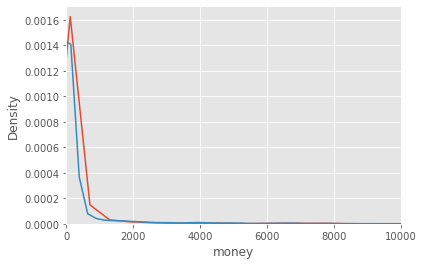

In [47]:
plt.xlim(0, 10000)
sns.kdeplot(df.query("group == 'group_1'").money)
sns.kdeplot(df.query("group == 'group_2'").money)

In [48]:
metric = 'money'

print(metric)
values_A = df.query("group == 'group_1'")[metric]
values_B = df.query("group == 'group_2'")[metric]
values_C = df.query("group == 'group_3'")[metric]

print('%PU A =', values_A[values_A>0].count() / values_A.count())
print('%PU B =', values_B[values_B>0].count() / values_B.count())
print('%PU C =', values_C[values_C>0].count() / values_C.count())

print()

print('%PU C / %PU A % =', ((values_C[values_C>0].count() / values_C.count()) / (values_A[values_A>0].count() / values_A.count()) - 1) * 100)
print('%PU B / %PU A % =', ((values_B[values_B>0].count() / values_B.count()) / (values_A[values_A>0].count() / values_A.count()) - 1) * 100)

print()

print('ARPPU A =', values_A[values_A>0].mean())
print('ARPPU B =', values_B[values_B>0].mean())
print('ARPPU C =', values_C[values_C>0].mean())

print()

print('ARPPU C / ARPPU A % =', (values_C[values_C>0].mean() / values_A[values_A>0].mean() - 1) * 100)
print('ARPPU B / ARPPU A % =', (values_B[values_B>0].mean() / values_A[values_A>0].mean() - 1) * 100)

print()

print('ARPU A =', values_A.mean())
print('ARPU B =', values_B.mean())
print('ARPU C =', values_C.mean())

print()

print('ARPU C / ARPU A % =', (values_C.mean() / values_A.mean() - 1) * 100)
print('ARPU B / ARPU A % =', (values_B.mean() / values_A.mean() - 1) * 100)

money
%PU A = 0.18969524553280898
%PU B = 0.1303934719427677
%PU C = nan

%PU C / %PU A % = nan
%PU B / %PU A % = -31.261602484277685

ARPPU A = 1571.7651440893942
ARPPU B = 2281.571367338191
ARPPU C = nan

ARPPU C / ARPPU A % = nan
ARPPU B / ARPPU A % = 45.15981448742616

ARPU A = 298.15637492794855
ARPU B = 297.5020120724346
ARPU C = nan

ARPU C / ARPU A % = nan
ARPU B / ARPU A % = -0.21946968454794602


C:\Users\adilbek\AppData\Local\Temp/ipykernel_26308/2674973280.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  print('%PU C =', values_C[values_C>0].count() / values_C.count())
C:\Users\adilbek\AppData\Local\Temp/ipykernel_26308/2674973280.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  print('%PU C / %PU A % =', ((values_C[values_C>0].count() / values_C.count()) / (values_A[values_A>0].count() / values_A.count()) - 1) * 100)


In [49]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество |бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = [len(data_column_1), len(data_column_2)]
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len[0], 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len[1], # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    print({"quants": quants, 
            "p_value": p_value,
          "mean:": np.mean(boot_data)})

# ARPU

  0%|          | 0/10000 [00:00<?, ?it/s]

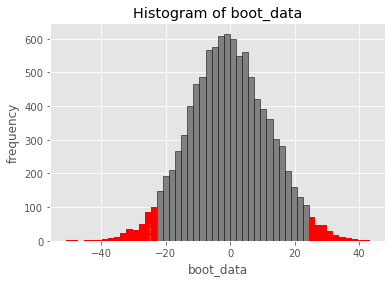

{'quants':                0
0.025 -24.823380
0.975  24.084992, 'p_value': 0.964225470705266, 'mean:': -0.5610021608936889}


In [41]:
get_bootstrap(
    df.query("group == 'group_2'")['money'], # числовые значения первой выборки
    df.query("group == 'group_1'")['money'], # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

# ARPPU

  0%|          | 0/10000 [00:00<?, ?it/s]

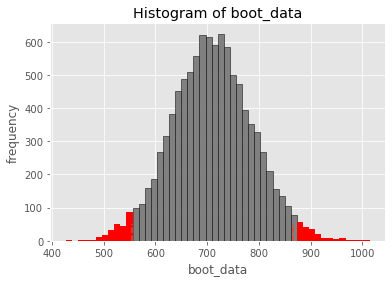

{'quants':                 0
0.025  555.173685
0.975  865.249164, 'p_value': 6.627889111926226e-20, 'mean:': 709.3831876217552}


In [42]:
get_bootstrap(
    df.query("group == 'group_2' & money > 0")['money'], # числовые значения первой выборки
    df.query("group == 'group_1' & money > 0")['money'], # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

# %PU

In [54]:
def conversion_rate_hyp(data, groups, metric, alt):
    data = data.query("group == @groups")
    data = data.groupby(['group'])\
               .agg({metric: 'sum', 'global_id': 'nunique'}).reset_index()
    chi2stat, pval = proportion.proportions_ztest(data[metric], data.global_id, alternative = alt)
    return 'P value:', pval, 'Statistics:', chi2stat

In [55]:
print('%PU')
print(conversion_rate_hyp(df, ['group_1', 'group_2'], 'payers', 'larger'))

%PU
('P value:', 1.976070179912734e-73, 'Statistics:', 18.08813828757735)
